# Drone localization on an aerial map

### Intoduction
In this task we'll help a drone to navigate in a unknown environment.  
To solve this task we will use drone's camera and a aerial map of the area in which it's flying.  
For simplicity we assume that camera is pointed straight down all the time and localization must be done in image coordinates meaning your task is to estimate location of drone's image center on the map.  
Here you can see an example of map on the left with virtual field of view of the drone and corresponding image on the right.

### Dataset structure

Dataset consists of 4 sequences with images captured by drone and metadata.csv file containing it's telemetry for each frame.  
Additionaly **map.png** contains aerial view of the environment.  
**metadata.csv: position_x, position_y, angle, scale**  
Position data is for reference only, to compare your result to actual position.  
Angle indicates orientation of drone obtained by magnetometer.  
Scale indicates ratio between map's and image's scales calculated from barometer measurements.  
Here you can see an example of drone's trajectory:  


## Part 1 - Classic Computer Vision

In this part you are required to develop localization algorithm using classical computer vision.  
You may use OpenCV and NumPy libraries.  

##### Written part:
Q: How would you define this problem? (e.g. object detection, image classification, etc.)   
A: I would say that this is template matching as we need to find a smaller part of the image inside the large image and "color it"

Q: Which high-level approaches to this problem you can think of?  
A: We have a large map and a small picture of which locations we need to idnetify - we need to match our picture to the map by traversing the map (through x,y) and match the entire picture pixesl for each x,y on the map that matches the 0,0 of our picture.

Q: For each of the following functions of OpenCV explain what is the approach and whether it's applicable for our problem and why?  
 - SIFT  
 - calcOpticalFlowPyrLK    
 - matchTemplate    
 - calcOpticalFlowFarneback  

A: SIFT finds distinctive features of the small image inside the map which are not affected by angle/scale, which is helpful in finding our images coreners as x,y on the big map for later matching given rotations/scale changes.
calcOpticalFlowPyrLK helps track similarities between different frames, which can help us if we need to track object movement between different frames - not our case.
matchTemplate will slide a template across an image looking for matches, which is exactly what our case is about - "image==template" which we want to slide above our map - given a fixed scale.
calcOpticalFlowFarneback compares two images in search for dense optical field - motion, not our case.

Q: What is the best approach in your opinion and why:  
A: I think that the most simple solution is to use an existing function - matchTemplate which exactly matches our simple case. We will use it to slide our given drone image across the whole map and find best matching position - returning the X,Y where the match to our images top-left is the best. We can simply slide it because of the fixed rotation and scale.
Upon advancing to section B and C, i realised that maybe SIFT is better for section C, as matchTemplate deals with rotation quite nice so its still fine for B.

### Section A
In first sequence drone's gimbal was fixed on north and he flew on a constant height such that scale of its images precisely equals to map's scale.  


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 30]

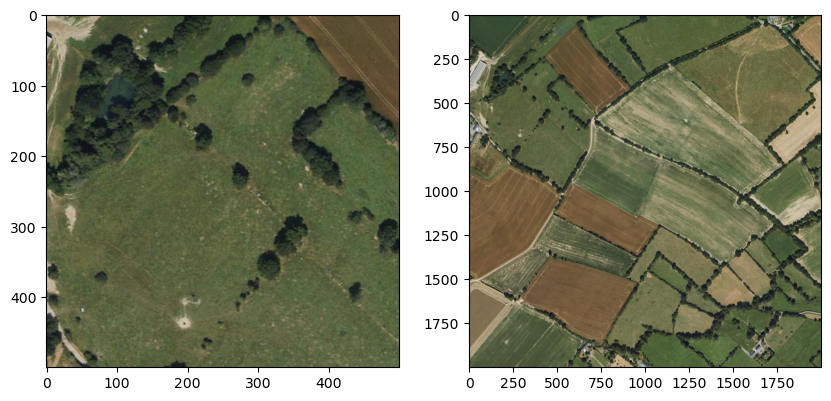

In [2]:
root_fld = './' #/drive/MyDrive/navigation_task/'

frame = cv2.cvtColor(cv2.imread(root_fld+'seq01/frame_000.png'),cv2.COLOR_BGR2RGB)
map_image = cv2.cvtColor(cv2.imread(root_fld+'map.png'),cv2.COLOR_BGR2RGB)
metadata = np.loadtxt(root_fld + 'seq01/metadata.csv', delimiter=',')

fig, axs = plt.subplots(1,2)
axs[0].imshow(frame)
axs[1].imshow(map_image)


In [3]:
def estimate_position_v1(frame,map_image):
    loc = np.array([0,0])
    ## Your code here
    # Converting to greyscale will result in better template matching
    frame_greyscale = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    map_image_grayscale = cv2.cvtColor(map_image, cv2.COLOR_RGB2GRAY)

    matching_result = cv2.matchTemplate(map_image_grayscale,frame_greyscale,cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(matching_result)

    # max_loc == image top_left corner, need to convert to image center
    frame_height, frame_width = frame.shape[:2]
    center_x = max_loc[0] + frame_width // 2
    center_y = max_loc[1] + frame_height // 2
    loc = np.array([center_x, center_y])

    ##
    return loc

Now write the evaluation code which compares results of your algorithm to the telemetry.  
Plot the error for each frame and calculate mean/std deviation.

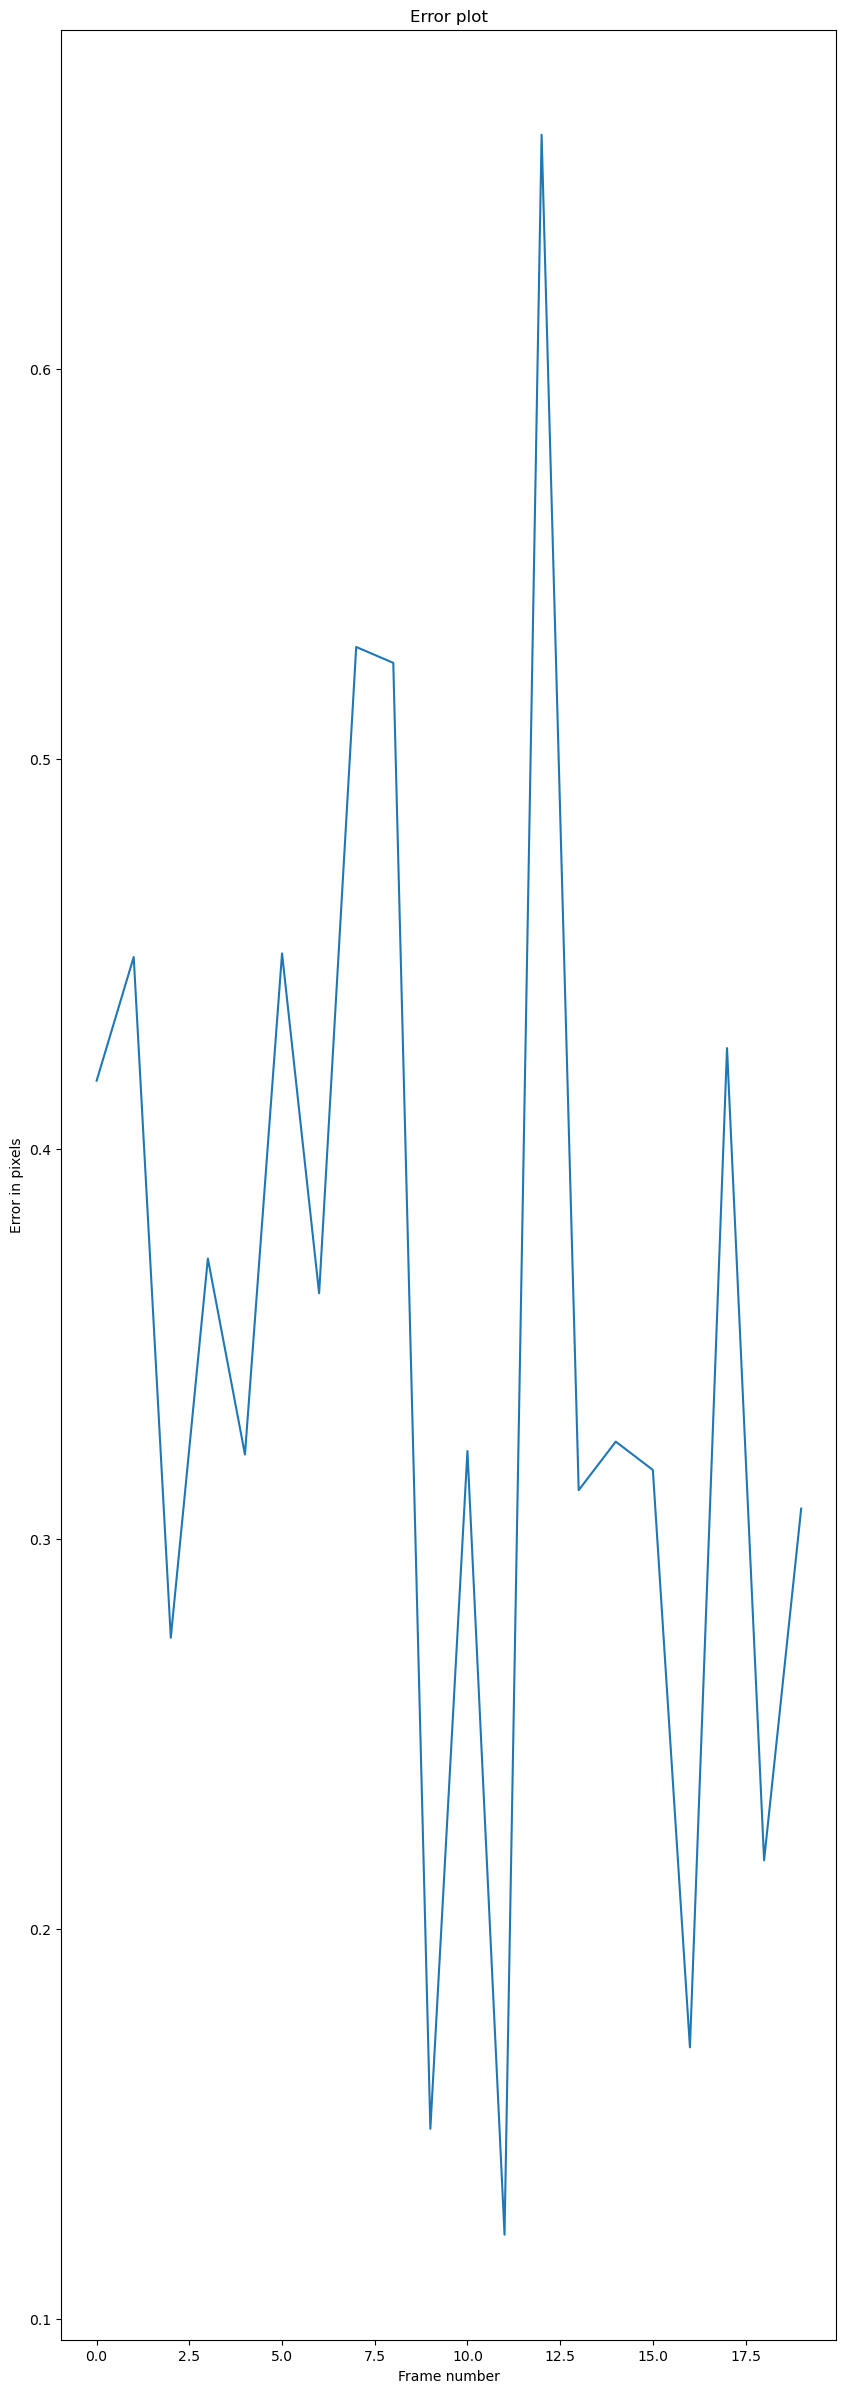

Mean of errors: 0.35145853669682714 
STD deviation of errors: 0.13120498078549436


In [4]:
## Your code here
import math

map_image = cv2.cvtColor(cv2.imread(root_fld+'map.png'),cv2.COLOR_BGR2RGB)
metadata = np.loadtxt(root_fld + 'seq01/metadata.csv', delimiter=',')

errors_list = []

for i in range(len(metadata)):
    frame_file = root_fld+f'seq01/frame_{i:03d}.png'
    frame_image = cv2.cvtColor(cv2.imread(frame_file),cv2.COLOR_BGR2RGB)

    estimated_pos = estimate_position_v1(frame_image,map_image)
    given_pos = metadata[i][:2]

    error = math.dist(estimated_pos,given_pos)
    errors_list.append(error)

plt.plot(errors_list)
plt.title('Error plot')
plt.xlabel('Frame number')
plt.ylabel('Error in pixels')
plt.show()

print("Mean of errors:",np.mean(errors_list),"\nSTD deviation of errors:",np.std(errors_list))

##

### Section B
In the second sequence the gimbal is no longer fixed. Modify your function to deal with this change and evaluate the result once again.

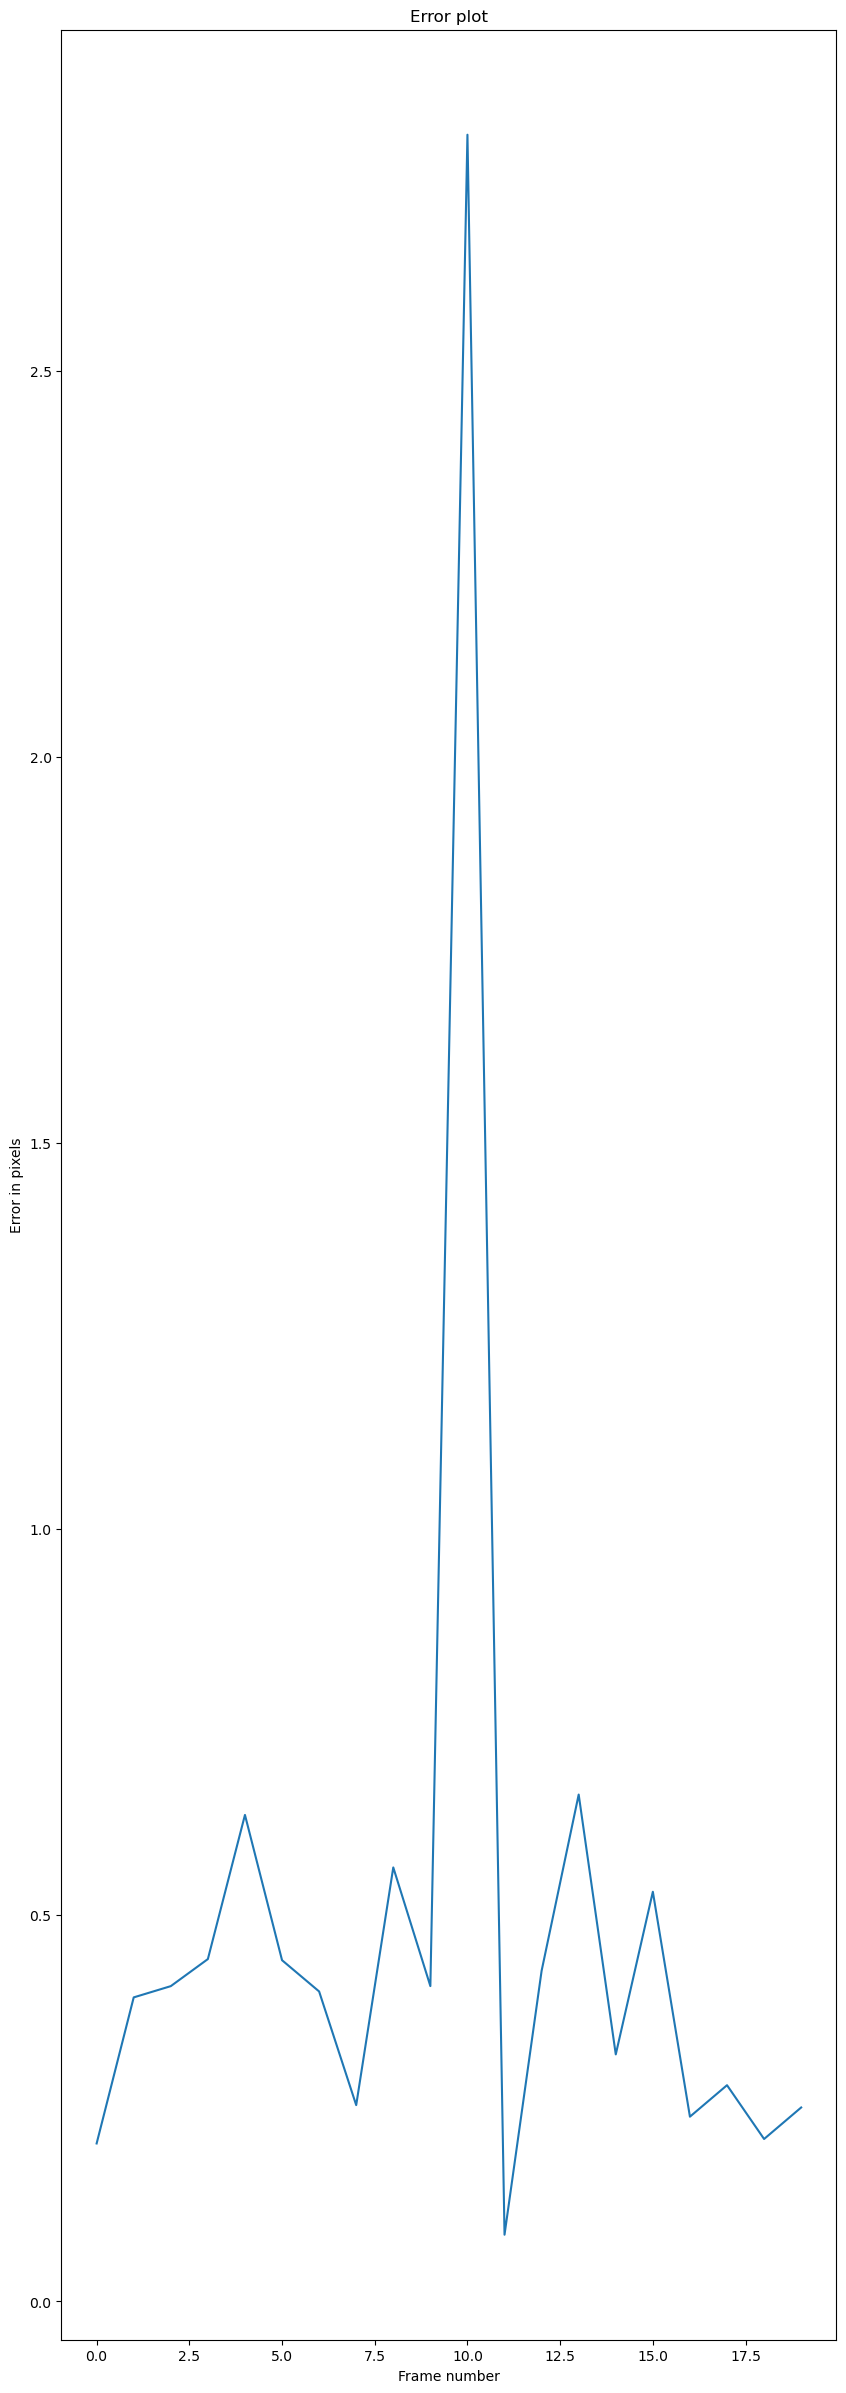

Mean of errors: 0.4978637846787047 
STD deviation of errors: 0.5489171630632402


In [5]:
def estimate_position_v2(frame,map_image,angle):
    loc = np.array([0,0])
    ## Your code here
    # Now we need to handle image rotation. We will rotate drone image as its smaller in size - thus faster.
    # The problem with this approach is that we rotate a smaller image and so we lose more info.
    # Converting to greyscale will result in better template matching
    frame_greyscale = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Rotation occours around the center
    frame_height, frame_width = frame.shape[:2]
    center = (frame_width //2 , frame_height //2)

    # After getting a huge error with +angle, I understood that the rotation is clockwise (+deg) and we need to compensate for it with (-deg)
    rotation_matrix = cv2.getRotationMatrix2D(center,-angle,1.0)
    rotated_frame_grey = cv2.warpAffine(frame_greyscale,rotation_matrix,(frame_width,frame_height))

    map_image_grayscale = cv2.cvtColor(map_image, cv2.COLOR_RGB2GRAY)

    matching_result = cv2.matchTemplate(map_image_grayscale,rotated_frame_grey,cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(matching_result)

    # max_loc == image top_left corner, need to convert to image center
    center_x = max_loc[0] + frame_width // 2
    center_y = max_loc[1] + frame_height // 2
    loc = np.array([center_x, center_y])
    ##
    return loc

## Your code here

map_image = cv2.cvtColor(cv2.imread(root_fld+'map.png'),cv2.COLOR_BGR2RGB)
metadata = np.loadtxt(root_fld + 'seq02/metadata.csv', delimiter=',')

errors_list = []

for i in range(len(metadata)):
    frame_file = root_fld+f'seq02/frame_{i:03d}.png'
    frame_image = cv2.cvtColor(cv2.imread(frame_file),cv2.COLOR_BGR2RGB)

    estimated_pos = estimate_position_v2(frame_image,map_image,angle=metadata[i][2])
    given_pos = metadata[i][:2]

    error = math.dist(estimated_pos,given_pos)
    errors_list.append(error)

plt.plot(errors_list)
plt.title('Error plot')
plt.xlabel('Frame number')
plt.ylabel('Error in pixels')
plt.show()

print("Mean of errors:",np.mean(errors_list),"\nSTD deviation of errors:",np.std(errors_list))
##

### Section C
Now in the third sequence drone's height changed. Modify your solution to adjust to this and run the evaluation.

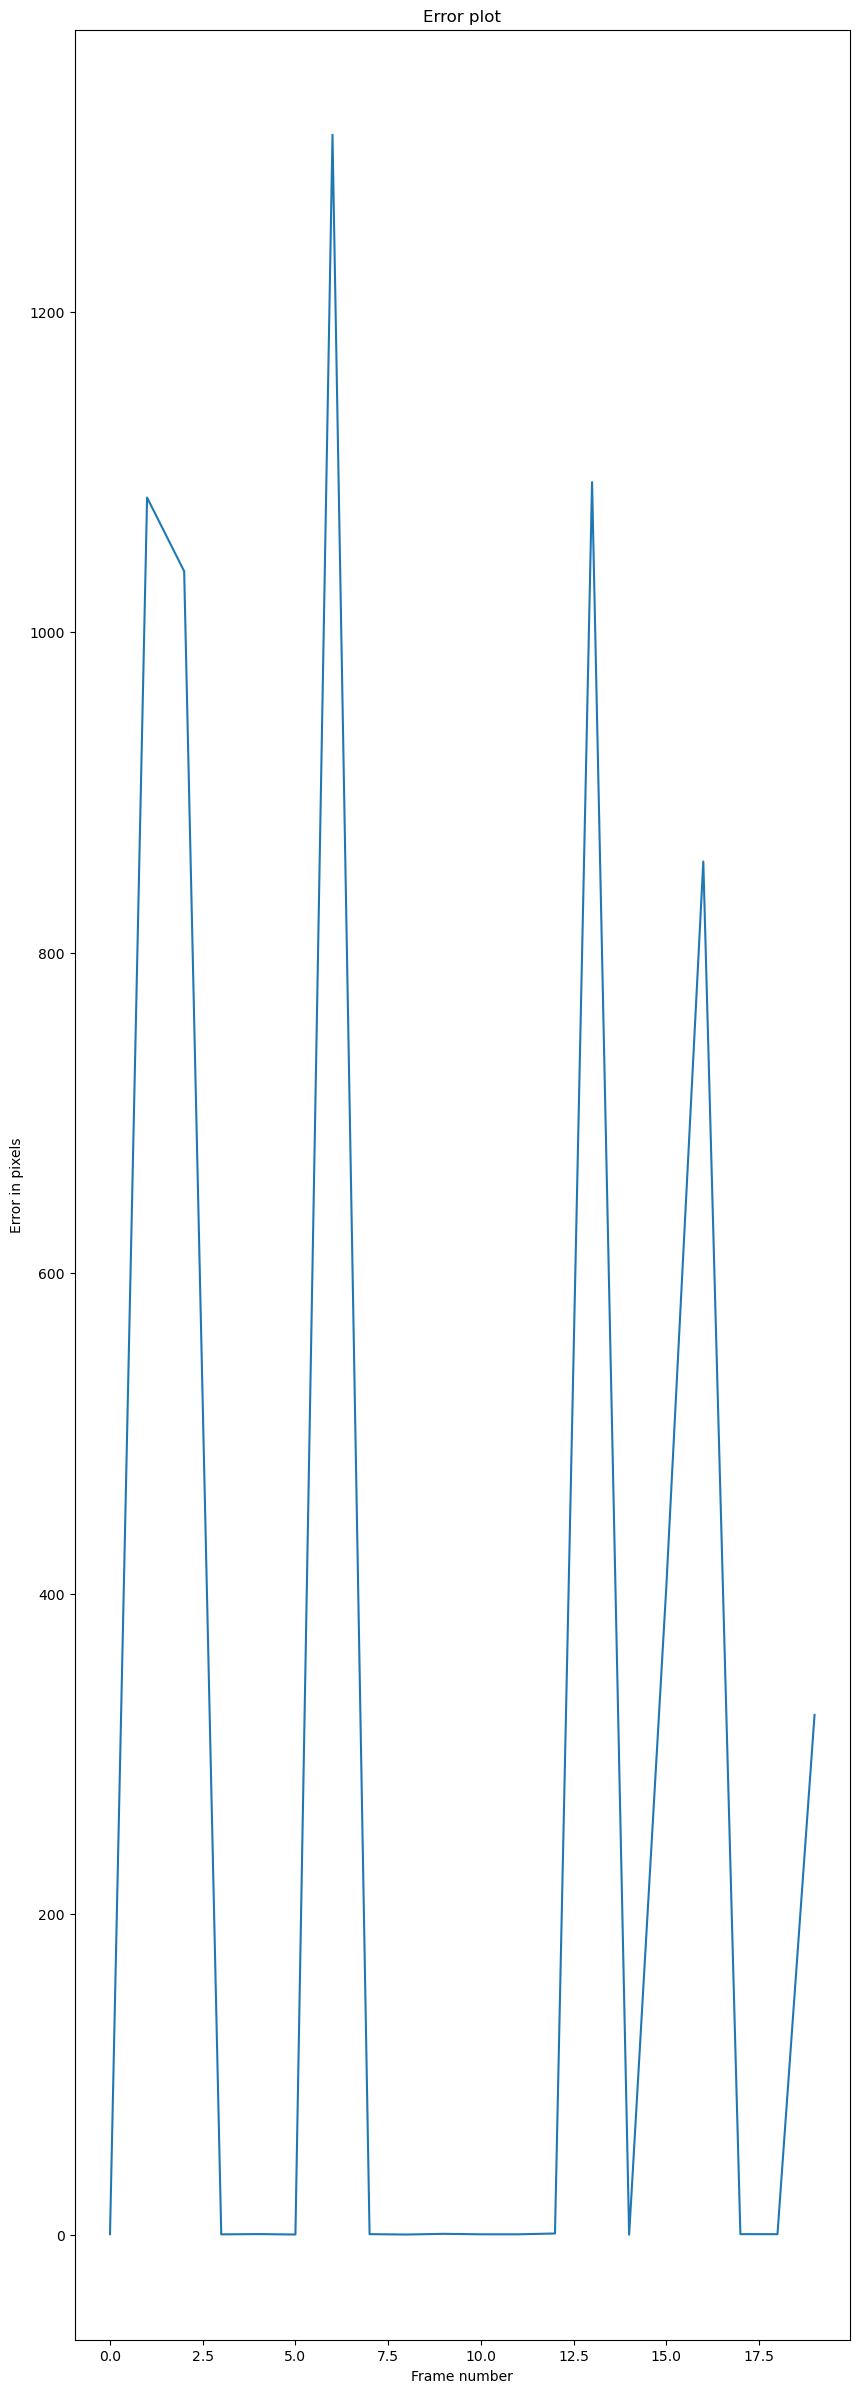

Mean of errors: 305.78378132024824 
STD deviation of errors: 463.54944554717207


In [6]:
def estimate_position_v3(frame,map_image,angle,scale):
    loc = np.array([0,0])
    ## Your code here
    # Now we need to handle image rotation and scale. We will rotate drone image as its smaller in size - thus faster.
    # The problem with this approach is that we rotate a smaller image and so we lose more info.
    # Another problem is the scale. The scale is actually resolution - meaning that in the resized picture, each pixel is not worth to 1 pixel in the original map image!
    # We need to start by resizing the image by scale in order to
    # match the drones original resolution - which is the one used to photograph the orignal map (scale = map/image)
    frame_height, frame_width = int(frame.shape[0]*scale) , int(frame.shape[1]*scale)
    resized_frame = cv2.resize(frame,(frame_width,frame_height))

    # Converting to greyscale will result in better template matching
    frame_greyscale = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)

    # Rotation occours around the center
    center = (frame_width //2 , frame_height //2)

    # After getting a huge error with +angle, I understood that the rotation is clockwise (+deg) and we need to compensate for it with (-deg)
    rotation_matrix = cv2.getRotationMatrix2D(center,-angle,1.0)
    rotated_frame_grey = cv2.warpAffine(frame_greyscale,rotation_matrix,(frame_width,frame_height))
    map_image_grayscale = cv2.cvtColor(map_image, cv2.COLOR_RGB2GRAY)

    matching_result = cv2.matchTemplate(map_image_grayscale,rotated_frame_grey,cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(matching_result)

    # max_loc == image top_left corner, need to convert to image center
    center_x = max_loc[0] + frame_width // 2
    center_y = max_loc[1] + frame_height // 2
    loc = np.array([center_x, center_y])

    ##
    return loc

## Your code here

map_image = cv2.cvtColor(cv2.imread(root_fld+'map.png'),cv2.COLOR_BGR2RGB)
metadata = np.loadtxt(root_fld + 'seq03/metadata.csv', delimiter=',')

errors_list = []

for i in range(len(metadata)):
    frame_file = root_fld+f'seq03/frame_{i:03d}.png'
    frame_image = cv2.cvtColor(cv2.imread(frame_file),cv2.COLOR_BGR2RGB)

    estimated_pos = estimate_position_v3(frame_image,map_image,angle=metadata[i][2],scale=metadata[i][3])
    given_pos = metadata[i][:2]

    error = math.dist(estimated_pos,given_pos)
    errors_list.append(error)

plt.plot(errors_list)
plt.title('Error plot')
plt.xlabel('Frame number')
plt.ylabel('Error in pixels')
plt.show()

print("Mean of errors:",np.mean(errors_list),"\nSTD deviation of errors:",np.std(errors_list))
##

## Part 2 - Training a Neural Network
While the classical approach is simple and offers great speed it wasn't robust enough to deal with challenging cases (e.g. new weather conditions or old maps), sequence 4 is such example.  
Best minds of the Department decided to train a neural network to adress this problem.  
During this part you should evaluate your approach on images from sequence 4.  

### Note:
You'll need a PC with good GPU to complete this exercise. If you don't have one consider using Google Collab for free.

### Approach
We decided to use the following architecture, which implements neural template matching:   
**XCorr**: module implements cross-correlation  
**MatchingNet**: applies fully-convolutional network on template and target, and returns the response of cross-correlating the features  

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class XCorr(nn.Module):

    def __init__(self):
        super(XCorr, self).__init__()

    def forward(self, z, x):
        out_scale = 1.0/np.prod(z.size()[1:])
        return self._fast_xcorr(z, x) * out_scale

    def _fast_xcorr(self, z, x):
        nz = z.size(0)
        nx, c, h, w = x.size()
        x = x.view(-1, nz * c, h, w)
        out = F.conv2d(x, z, groups=nz)
        out = out.view(-1, out.size(-2), out.size(-1))
        return out

class MatchingNet(nn.Module):

    def __init__(self, backbone, head):
        super(MatchingNet, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, z, x):
        z = self.backbone(z)
        x = self.backbone(x)
        return self.head(z, x)


### Example of usage
Apparently the architecture is working:

[343 501] [343.379 500.825] 0.41745179362414825


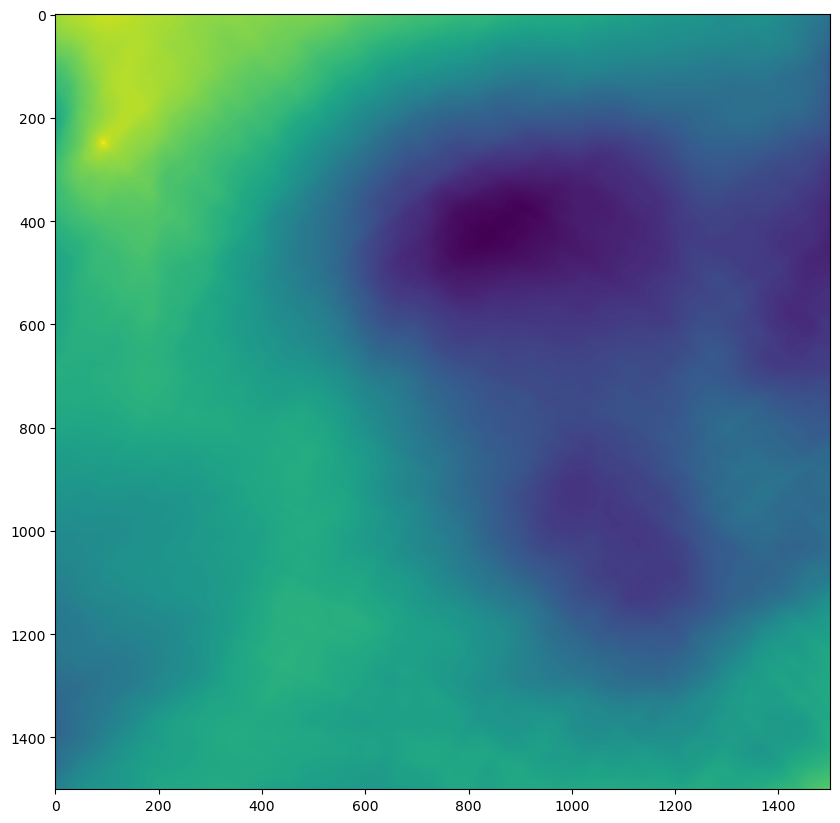

In [9]:
class DummyModel(nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()

    def forward(self, x):
        return x


def image_to_tensor(image):
    tensor = np.transpose(image[np.newaxis],[0,3,1,2]).astype(np.float32)/255.0-0.5
    tensor = torch.from_numpy(tensor)
    return tensor


frame = cv2.cvtColor(cv2.imread(root_fld+'seq01/frame_000.png'),cv2.COLOR_BGR2RGB)
map_image = cv2.cvtColor(cv2.imread(root_fld+'map.png'),cv2.COLOR_BGR2RGB)
position_gt = np.array([343.379,500.825])

frame_tensor = image_to_tensor(frame)
map_tensor = image_to_tensor(map_image)

net = MatchingNet(DummyModel(),XCorr())
device = 'cuda'
res = net(frame_tensor.to(device),map_tensor.to(device)).to(device)
corr = res.cpu().numpy().squeeze() # correlation between drone image and map will give the most likely places (=highest corr) on the map where our drone image might be
# What we did here is basically template matching with the correlation function
plt.figure()
plt.imshow(corr)


def calc_position_from_response(response,template_shape):
    pos = np.array([0,0])
    ## Your code here:
    # We need to find the spot which gives the highest(max) correlation between the drone img and the map
    _, _, _, max_loc = cv2.minMaxLoc(response)

    templ_h, temp_w = template_shape
    center_x = max_loc[0] + temp_w // 2
    center_y = max_loc[1] + templ_h // 2
    pos = np.array([center_x, center_y])

    ##
    return pos


pos = calc_position_from_response(corr,frame.shape[:2])

print(pos,position_gt,np.linalg.norm(pos-position_gt))

### Section A
Capturing real-world data appeared to be prohibitively expensive, so we'll need to use some kind of unsupervised method. One of developers in the Department offered to test pretrained resnet as a feature extractor.    
In this part you are required to implement the backbone using first num_layers out of 4 first blocks of Resnet.  
Use the implementaion found in **torchvision.models**:

In [11]:
import torchvision.models as models

num_layers = 3
resnet_preset = 50
pretrained = True

base_model = {
            18: models.resnet18,
            34: models.resnet34,
            50: models.resnet50,
            101: models.resnet101,
            152: models.resnet152
        }[resnet_preset](pretrained=pretrained)


def extract_convolutional_layers(base_model,num_layers):
    model = None
    ## Your code here
    # Our model would take initial sequence and first num_layers of resnet, so we need a chain from base_model
    model = nn.Sequential(base_model.conv1, base_model.bn1, base_model.relu ,base_model.maxpool) # Init
    # In original paper, it seems that init does not have relu, yet implementation guides shows that there is: https://d2l.ai/chapter_convolutional-modern/resnet.html
    original_layers = [base_model.layer1, base_model.layer2,base_model.layer3, base_model.layer4]
    model = nn.Sequential(model, *original_layers[:num_layers])
    ##
    return model

model = extract_convolutional_layers(base_model,num_layers).to(device) # Fix: moved model weights to cpu instead of response

response = model(frame_tensor.to(device))
#Response shape = [batch size, features lerned from resnet, height of feature matrix, width of feature matrix]
print(response.shape)

torch.Size([1, 1024, 32, 32])


Now let's evaluate this model. Construct a MatchingNet using new backbone and evaluate the result. You might need to modify **calc_position_from_response**:

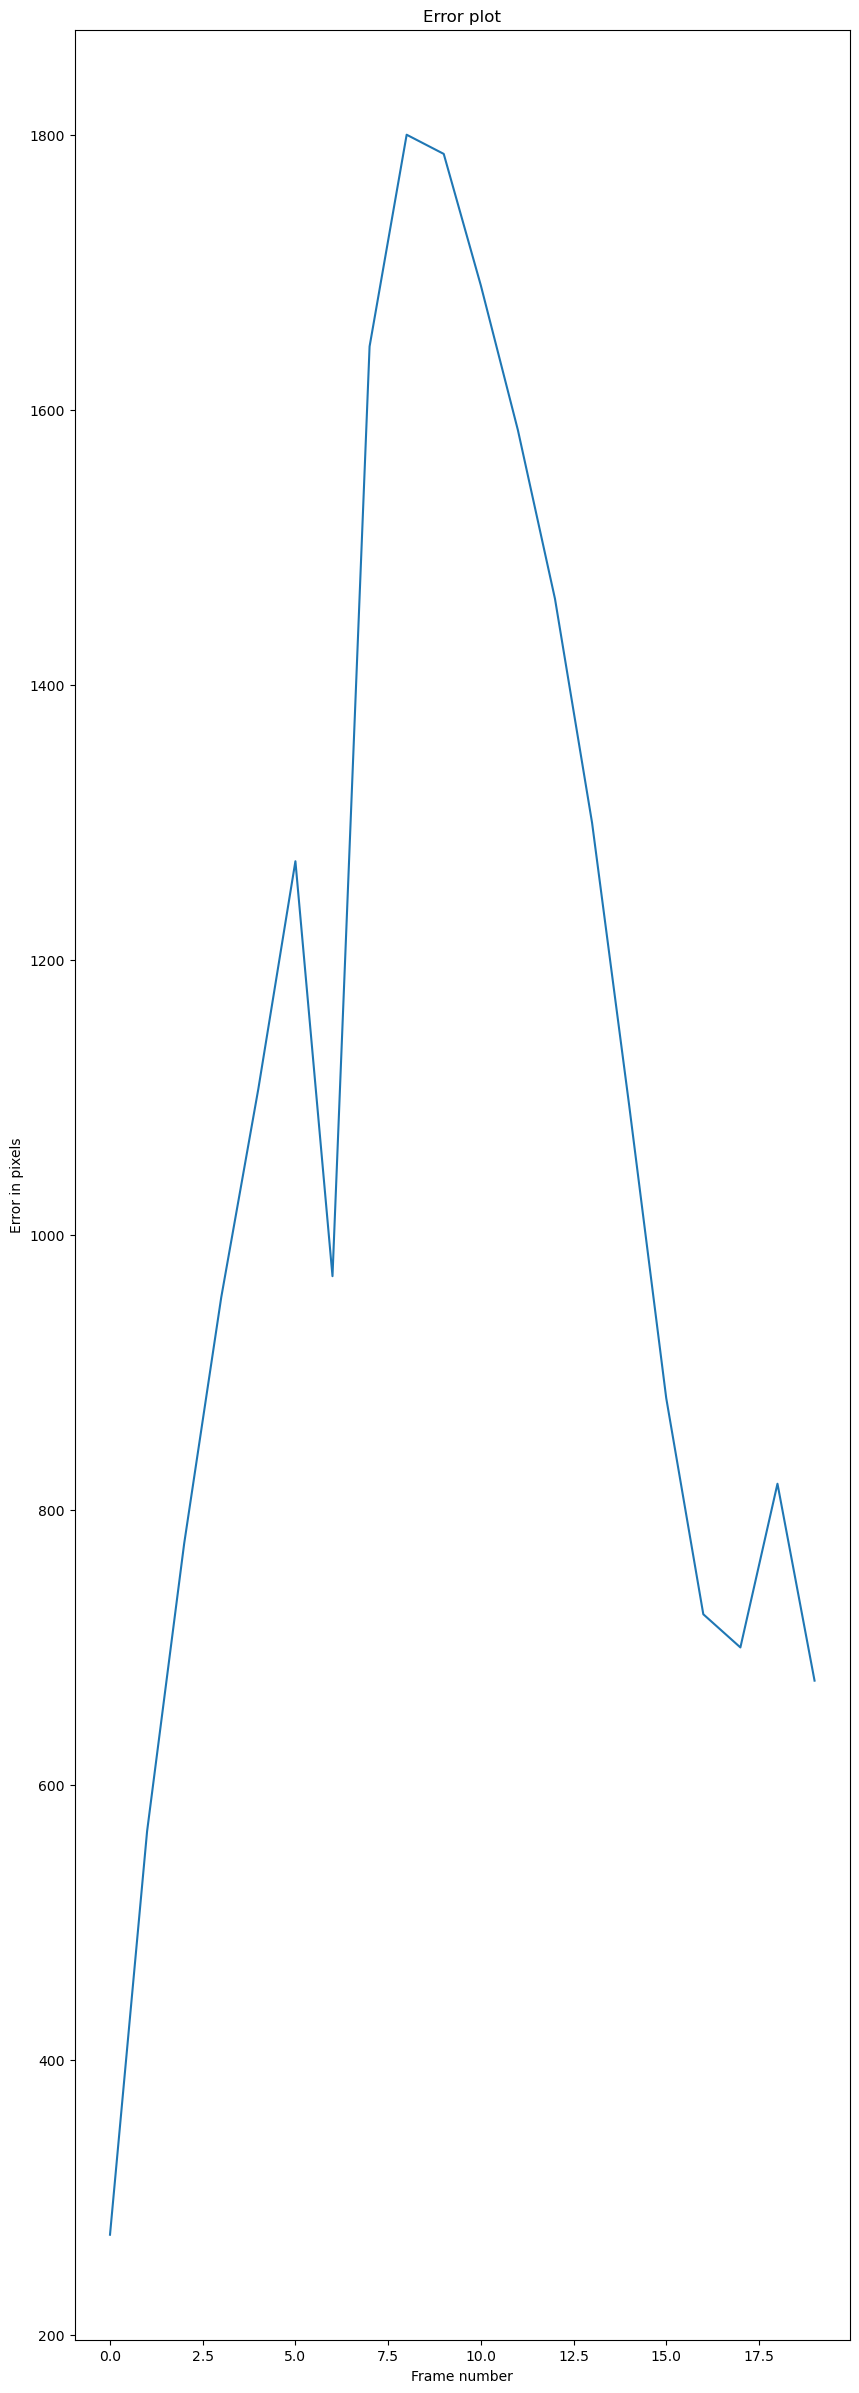

Mean of errors: 1104.1340627932855 
STD deviation of errors: 433.9000931882858


In [13]:
def calc_position_from_response(response,template_shape,num_layers):
    pos = np.array([0,0])
    ## Your code here:
    # Now response contains a smaller correlation as ResNet loves to do - so we need scaling
    _, _, _, max_loc = cv2.minMaxLoc(response)
    response_h, response_w = response.shape[:2]
    templ_h, templ_w = template_shape
    scaling = (templ_w / response_w, templ_h / response_h)

    max_loc = (max_loc[0] * scaling[0], max_loc[1] * scaling[1])

    center_x = max_loc[0] + templ_w // 2
    center_y = max_loc[1] + templ_h // 2
    pos = np.array([center_x, center_y])
    ##
    return pos

## Your code here:
torch.cuda.empty_cache() # Empty cache as i dont have nvidia GPU and google colab is jewish type of cheap
net = MatchingNet(model,XCorr()) # net with our "ResNet" model
device = 'cuda'
net = net.to(device)

metadata = np.loadtxt(root_fld + 'seq04/metadata.csv', delimiter=',')
map_image = cv2.cvtColor(cv2.imread(root_fld+'map.png'),cv2.COLOR_BGR2RGB)
map_tensor = image_to_tensor(map_image)

errors_list = []

for i in range(len(metadata)):
    frame_file = root_fld+f'seq04/frame_{i:03d}.png'
    frame_image = cv2.cvtColor(cv2.imread(frame_file),cv2.COLOR_BGR2RGB)
    frame_tensor = image_to_tensor(frame_image)
    position_gt = metadata[i][:2]

    # Some claude magic for mem management:
    # Prevents gradient accumulation
    with torch.no_grad():
        res = net(frame_tensor.to(device),map_tensor.to(device))
        corr = res.cpu().detach().numpy().squeeze()

    # Clear GPU cache periodically
    if i % 3 == 0:
        torch.cuda.empty_cache()
    # End of claude magic

    res = net(frame_tensor.to(device),map_tensor.to(device))
    corr = res.cpu().detach().numpy().squeeze()
    estimated_pos = calc_position_from_response(corr,frame_image.shape[:2],num_layers)

    error = np.linalg.norm(estimated_pos-position_gt)
    errors_list.append(error)

plt.plot(errors_list)
plt.title('Error plot')
plt.xlabel('Frame number')
plt.ylabel('Error in pixels')
plt.show()

print("Mean of errors:",np.mean(errors_list),"\nSTD deviation of errors:",np.std(errors_list))
##

### Section B
CTO wasn't satisfied with the result. He suggested re-training the network for satellite image classification.  
In this section you must implement code for training the ResNet on **AID** dataset (which you'll have to download). See explanation in documentation of **torchrs** library. You must do this using **pytorch_lightning** library.

In [14]:
from typing import Optional

import torchvision.transforms as T
import pytorch_lightning as pl
from torchrs.datasets import AID
import torchmetrics

## Your code here:
class AIDDataModule(pl.LightningDataModule):

    def __init__(
        self,
        root: str = "data/AID",
        transform: T.Compose = T.Compose([ # Couldve used augmentation but data is blurred
                               T.Resize((500, 500)), # Matching drone sample image size in pixels 
                               T.ToTensor(),
                               T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization numbers from ImageNet (thank you pytorch forum)
        ]),
        #T.Compose([T.ToTensor()]),
        batch_size=8,
        num_workers=16,
        prefetch_factor=1,
        val_split = 0.1,
        test_split = 0.2, 
        shuffle_data = False
    ):
        super().__init__(*args, **kwargs)
        self.root = root
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.prefetch_factor = prefetch_factor
        self.val_split = val_split
        self.test_split = test_split
        self.shuffle_data = shuffle_data

    def setup(self, stage: Optional[str] = None):
        dataset = AID(root=self.root, transform=self.transform)

        # Randomly splitting data across stages
        total_size = len(dataset)
        test_size = int(total_size * self.test_split)
        val_size = int(total_size * self.val_split)
        train_size = total_size - test_size - val_size

        self.test_dataset, self.val_dataset, self.train_dataset = torch.utils.data.random_split( dataset, [ test_size, val_size, train_size])

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset, batch_size=self.batch_size,
            shuffle=self.shuffle_data, num_workers=self.num_workers)
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset, batch_size=self.batch_size,
            shuffle=self.shuffle_data, num_workers=self.num_workers)
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, batch_size=self.batch_size,
            shuffle=self.shuffle_data, num_workers=self.num_workers)
        
##

In [23]:
class ResnetModule(pl.LightningModule):

    def __init__(
        self,
        channels: int = 3,
        num_classes: int = 2,
        resnet_preset: int = 50,
        pretrained: bool = True,
        loss_fn: nn.Module = nn.CrossEntropyLoss(),
        opt: torch.optim.Optimizer = torch.optim.Adam,
        lr: float = 1e-3
    ):
        super().__init__()
        self.loss_fn = loss_fn
        self.opt = opt
        self.lr = lr
        
        self.model = {
            18: models.resnet18, 
            34: models.resnet34,
            50: models.resnet50, 
            101: models.resnet101,
            152: models.resnet152
        }[resnet_preset](pretrained=pretrained)
        
        # Change the first convolutional layer to adjust to the number of input channels
        ## Your code here:
        # Source of exact functions is: https://docs.pytorch.org/vision/0.9/_modules/torchvision/models/resnet.html#
        # First conv layer is conv1 and it happens as a 7*7 in the start of the process.
        self.model.conv1 = nn.Conv2d(channels, self.model.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        ##
        
        # Change the last linear layer to adjust to the number of classes
        ## Your code here:
        # Last linear layer is actually FC which is the fully-connected network
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        ##
        
        metrics = torchmetrics.MetricCollection([
            torchmetrics.Accuracy(task='multiclass',threshold=0.5, num_classes=num_classes, average='macro'),
            torchmetrics.Precision(task='multiclass',num_classes=num_classes, threshold=0.5, average='macro'),
            torchmetrics.Recall(task='multiclass',num_classes=num_classes, threshold=0.5, average='macro'),
        ])
        self.train_metrics = metrics.clone(prefix='train/')
        self.val_metrics = metrics.clone(prefix='val/')
        self.test_metrics = metrics.clone(prefix='test/')

    def configure_optimizers(self):
        self.optimizer = self.opt(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer,T_max=50, eta_min=self.lr / 20)
        return [self.optimizer], [scheduler]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx: int):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        metrics = self.train_metrics(y_pred.softmax(dim=1), y)
        metrics["train/loss"] = loss
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx: int):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        metrics = self.val_metrics(y_pred.softmax(dim=1), y)
        metrics["val/loss"] = loss
        self.log_dict(metrics)

    def test_step(self, batch, batch_idx: int):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        metrics = self.test_metrics(y_pred.softmax(dim=1), y)
        metrics["test/loss"] = loss
        self.log_dict(metrics)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [ ]:
model = ResnetModule(channels=3, resnet_preset=34, num_classes=30, lr=1e-3)
break
dm = AIDAugmentedDataModule(
    root="../data/AID",
    batch_size=32,
    num_workers=48,
    prefetch_factor=1,
    val_split = 0.1,
    test_split = 0.2
)
callbacks = [
    pl.callbacks.ModelCheckpoint(monitor="val/loss", mode="min", verbose=True, save_top_k=1),
    pl.callbacks.EarlyStopping(monitor="val/loss", mode="min", patience=10)
]
trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=50,
    callbacks=callbacks,
    weights_summary="top"
)
trainer.fit(model, datamodule=dm)
trainer.test(datamodule=dm)

Let's run the evaluation once again.  
What value of **num_layers** worked the best?   

In [ ]:
model = ResnetModule(channels=3, resnet_preset=50, num_classes=30, lr=1e-3)
ckpt_path = '...'
model.load_state_dict(torch.load(ckpt_path)['state_dict'])
model.eval()
base_model = model.model
backbone = extract_convolutional_layers(base_model,num_layers)

## Your code here:

##

### Section C
Now, we would like to train the model in a supervised way.  
In this section you are aked to outline your approach to solving this problem.  

**Q**: Ideally, what real-world data for this task is needed? Describe the format.  
**A**:  

**Q**: Capturing real-world data appeared to be prohibitively expensive.  
Assuming you have a large dataset of satellite images could you build a synthetic dataset? How?   
**A**:

**Q**: We have an access to a change detection dataset containing pairs of satellite images and mask where there are significant changes between the map.
How can be change detection dataset be useful?  
**A**:  

**Q**: Assuming we are using the same architecture, propose a loss for supervision. What challanges we would adress in this loss?  
**A**:  

**Q**: What metrics for training the net you would define?  
**A**:  

**Q**: How would you change the architecture to increase the accuracy and decrease impact of quantization caused by lowering spatial resolution, while keeping the network efficient?  
**A**:  